In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# Load the dataset
data = pd.read_csv('worldometer_coronavirus_daily_data.csv')


In [3]:
# Filter data for India
india_data = data[data['country'] == 'India'].copy()

# Handle missing values by forward filling and then filling any remaining NaNs with zeros
india_data.ffill(inplace=True)
india_data.fillna(0, inplace=True)


In [4]:
# Convert the 'date' column to datetime format
india_data['date'] = pd.to_datetime(india_data['date'], errors='coerce')

# Drop any rows where 'date' conversion failed
india_data.dropna(subset=['date'], inplace=True)

# Sort by date to maintain sequential order
india_data.sort_values('date', inplace=True)
india_data.reset_index(drop=True, inplace=True)


In [5]:
# Convert the date to a numerical value (days since the first date)
india_data['date'] = (india_data['date'] - india_data['date'].min()).dt.days


In [6]:
# Create rolling averages to smooth out the daily fluctuations
india_data['daily_new_cases_avg'] = india_data['daily_new_cases'].rolling(window=7).mean().fillna(0)
india_data['daily_new_deaths_avg'] = india_data['daily_new_deaths'].rolling(window=7).mean().fillna(0)


In [7]:
# Create lagged features
for lag in range(1, 4):  # Creating 3 lagged features
    india_data[f'lagged_cumulative_cases_{lag}'] = india_data['cumulative_total_cases'].shift(lag)

# Drop NaNs that resulted from lagging
india_data.dropna(inplace=True)


In [8]:
# Selecting relevant features for training and target column
features = ['date', 'daily_new_cases_avg', 'active_cases', 'cumulative_total_deaths', 
            'daily_new_deaths_avg', 'lagged_cumulative_cases_1', 'lagged_cumulative_cases_2', 
            'lagged_cumulative_cases_3']
target = 'cumulative_total_cases'

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
india_data[features] = scaler.fit_transform(india_data[features])

# Scale the target variable
target_scaler = MinMaxScaler()
india_data[[target]] = target_scaler.fit_transform(india_data[[target]])

# Ensure the target variable does not contain NaNs or infinities
india_data[target] = india_data[target].replace([np.inf, -np.inf], np.nan)
india_data.dropna(subset=[target], inplace=True)


In [9]:
import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [11]:
# Create sequences for supervised learning
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 30
X, y = create_sequences(india_data, seq_length)


In [12]:
# Split data into training and testing sets (first 80% for training)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [13]:
# Build a Bidirectional LSTM model with more complexity
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))  # Adding L2 Regularization
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), loss='mse')


In [14]:
# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr], verbose=1)


Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - loss: 0.1932 - val_loss: 0.1487 - learning_rate: 5.0000e-05
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0386 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0317 - val_loss: 0.0293 - learning_rate: 5.0000e-05
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0284 - val_loss: 0.0254 - learning_rate: 5.0000e-05
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0262 - val_loss: 0.0240 - learning_rate: 5.0000e-05
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0258 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0250 - val_loss: 0.0231 - learning_rate: 5.0000e-05
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0249 - val_loss: 0.0229 - learning_rate: 2.5000e-05
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0254 - val_loss: 0.0224 

In [15]:
# Predict on both training and testing sets
y_train_pred = model.predict(X_train).squeeze()
y_test_pred = model.predict(X_test).squeeze()


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [16]:
# Inverse scale the predictions and the true values
y_train = target_scaler.inverse_transform(y_train.reshape(-1, 1)).squeeze()
y_train_pred = target_scaler.inverse_transform(y_train_pred.reshape(-1, 1)).squeeze()
y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).squeeze()
y_test_pred = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1)).squeeze()

# Calculate evaluation metrics for training
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Calculate evaluation metrics for testing
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Print the metrics
print('Training Data Metrics:')
print(f'Mean Absolute Error (MAE): {mae_train}')
print(f'Mean Squared Error (MSE): {mse_train}')
print(f'Root Mean Squared Error (RMSE): {rmse_train}')
print(f'R-squared (R²): {r2_train}')

print('\nTesting Data Metrics:')
print(f'Mean Absolute Error (MAE): {mae_test}')
print(f'Mean Squared Error (MSE): {mse_test}')
print(f'Root Mean Squared Error (RMSE): {rmse_test}')
print(f'R-squared (R²): {r2_test}')


Training Data Metrics:
Mean Absolute Error (MAE): 453706.762434967
Mean Squared Error (MSE): 383846334464.88245
Root Mean Squared Error (RMSE): 619553.3346410803
R-squared (R²): 0.9976805458586024

Testing Data Metrics:
Mean Absolute Error (MAE): 623100.6202531646
Mean Squared Error (MSE): 495542810605.1519
Root Mean Squared Error (RMSE): 703948.0169765037
R-squared (R²): 0.9562787496591073


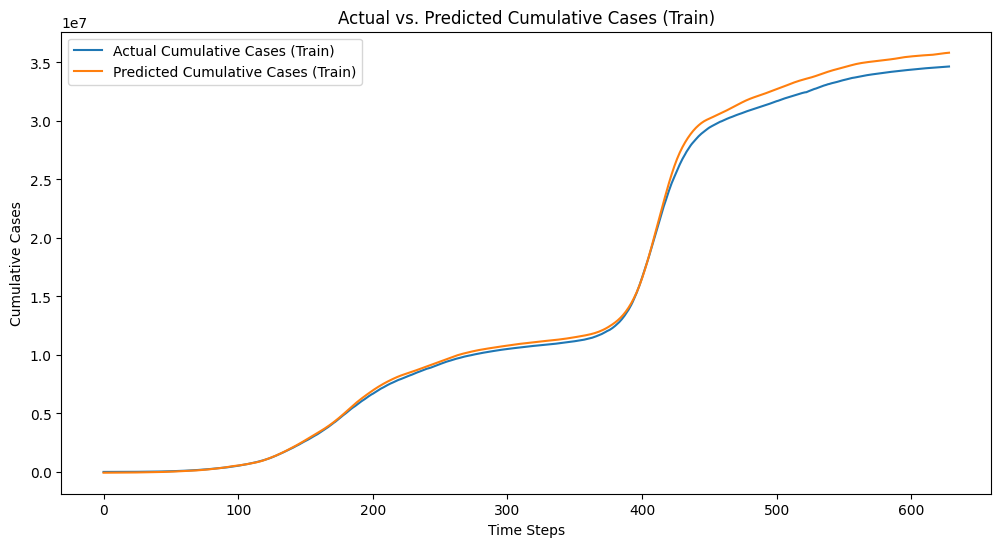

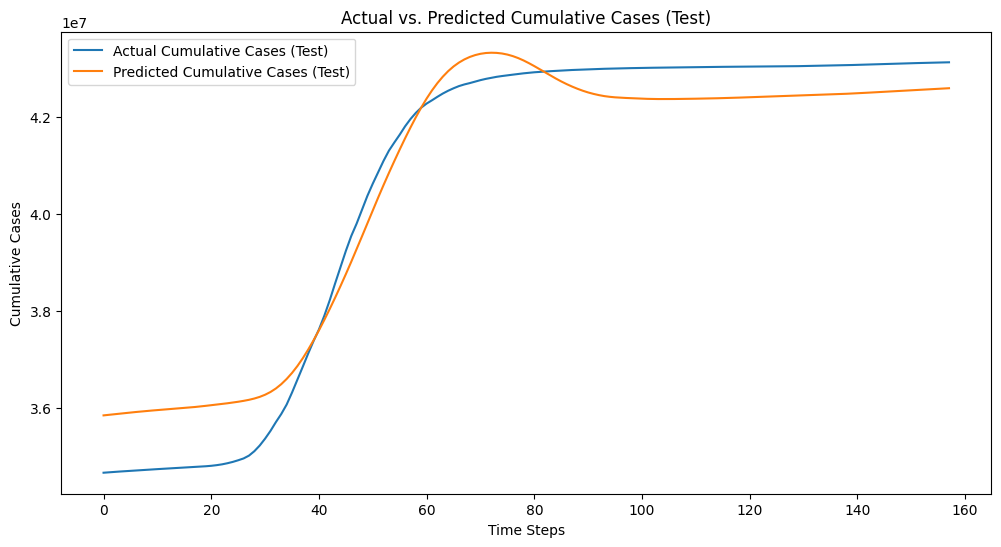

In [17]:
# Plot the actual vs. predicted cumulative cases for training data
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual Cumulative Cases (Train)')
plt.plot(y_train_pred, label='Predicted Cumulative Cases (Train)')
plt.title('Actual vs. Predicted Cumulative Cases (Train)')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Cases')
plt.legend()
plt.show()

# Plot the actual vs. predicted cumulative cases for testing data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Cumulative Cases (Test)')
plt.plot(y_test_pred, label='Predicted Cumulative Cases (Test)')
plt.title('Actual vs. Predicted Cumulative Cases (Test)')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Cases')
plt.legend()
plt.show()


In [20]:
model.save('covid_model.h5')